In [120]:
import json
import pandas as pd
import gzip
from bs4 import BeautifulSoup


# load the profiles database and produce a table keyed on player/year?
def load_profiles(file_name="player_profiles.json"):
    opener = gzip.open if file_name.endswith(".gz") else open
    with opener(file_name, "r") as f:
        js = json.load(f)
    result_sets = js["resultSets"][0]
    headers = result_sets["headers"]
    data_rows = result_sets["rowSet"]

    data_dict = {
        header : [ 
            data_row[ctr]
            for data_row in data_rows
        ]
        for ctr, header in enumerate(headers)
    }

    df = pd.DataFrame(data_dict)
    return df


# load the injury data for each file
def load_injury_data(file_name: str):

    # these are the columns we expect, in the order we expect them
    expected_columns = ["Player","Position","Updated","Injury","Injury Status"]
    
    # these are the columns whose names need to be rewritten old->new
    rewrite_columns = { "Expected Return": "Injury Status", "Pos": "Position" }
    
    with open(file_name) as fp:
        html_data = BeautifulSoup(fp, 'html.parser')
    # construct the header
    first_table = (html_data.find("table", {"class": "TableBase-table"}) or
            html_data.find("table", {"class": "data"}))
    header = [
        th.text.strip()
        for th in (
            (first_table.find_all("th", {"class": "TableBase-headTh"}) or 
            first_table.find("tr", {"id": "special"}).find_all("td"))
        )
    ]
    # construct the data
    injuries = {
        hdr: []
        for hdr in expected_columns
    }
    tables = (html_data.find_all("table", {"class": "TableBase-table"}) or
            html_data.find_all("table", {"class": "data"}))
    for table in tables:
        # this is broken for years before 2017
        for row in table.find_all("tr"):
            if (not ("bodyTr" in row.attrs["class"][0] or "row" in row.attrs["class"][0])) or ("id" in row.attrs):
                continue
            # TODO: you need to special handle the Player name field (first one)
            # there is a span called "CellPlayerName--long" that needs to be extracted
            cells = [
                (cell.find("span", {"class": "CellPlayerName--long"}) or cell).text.strip() 
                for ctr, cell in enumerate(
                row.find_all("td")
                )
            ]
            if len(cells) < len(header):
                continue
            for ctr, hdr in enumerate(header):
                injuries[rewrite_columns.get(hdr, hdr)].append(cells[ctr])
    df = pd.DataFrame(injuries)
    return df


# EF: to get all injury data, you need the data from every year
def load_injury_data_from_all_years(base_name: str = "nbainjuries.html",
                                    start_year: int = 2012, end_year: int = 2021):
    all_year_data = []
    for year in range(start_year, end_year+1):
        year_file_name = f"{year}{base_name}"
        print(f"trying {year_file_name}")
        all_year_data.append(load_injury_data(year_file_name))
    return pd.concat(all_year_data)



In [121]:
def load_player_game_data_from_all_years(base_name: str = "season_data",
                                    start_year: int = 2011, end_year: int = 2020):
    all_year_data = []
    for year in range(start_year, end_year+1):
        year_file_name = f"{base_name}_{year}_{year - 2000 + 1}.json.gz"
        print(f"trying {year_file_name}")
        all_year_data.append(load_profiles(year_file_name))
    return pd.concat(all_year_data)


In [122]:
#3 sources= all years, player profiles, player_game
injury_data= load_injury_data_from_all_years()
player_data= load_profiles()
player_game= load_player_game_data_from_all_years()

trying 2012nbainjuries.html
trying 2013nbainjuries.html
trying 2014nbainjuries.html
trying 2015nbainjuries.html
trying 2016nbainjuries.html
trying 2017nbainjuries.html
trying 2018nbainjuries.html
trying 2019nbainjuries.html
trying 2020nbainjuries.html
trying 2021nbainjuries.html
trying season_data_2011_12.json.gz
trying season_data_2012_13.json.gz
trying season_data_2013_14.json.gz
trying season_data_2014_15.json.gz
trying season_data_2015_16.json.gz
trying season_data_2016_17.json.gz
trying season_data_2017_18.json.gz
trying season_data_2018_19.json.gz
trying season_data_2019_20.json.gz
trying season_data_2020_21.json.gz


In [123]:
#join the data
results= pd.merge(player_game, player_data)
print(results)

Empty DataFrame
Columns: [SEASON_ID, PLAYER_ID, PLAYER_NAME, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_ID, GAME_DATE, MATCHUP, WL, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, FANTASY_PTS, VIDEO_AVAILABLE, PERSON_ID, PLAYER_LAST_NAME, PLAYER_FIRST_NAME, PLAYER_SLUG, TEAM_SLUG, IS_DEFUNCT, TEAM_CITY, JERSEY_NUMBER, POSITION, HEIGHT, WEIGHT, COLLEGE, COUNTRY, DRAFT_YEAR, DRAFT_ROUND, DRAFT_NUMBER, ROSTER_STATUS, STATS_TIMEFRAME, FROM_YEAR, TO_YEAR]
Index: []


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1210: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


array([[<AxesSubplot:title={'center':'PLUS_MINUS'}>]], dtype=object)

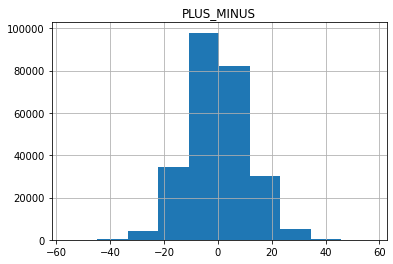

In [124]:
player_game.hist("PLUS_MINUS")

In [125]:
player_data
player_data.head(5)

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
0,76001,Abdelnaby,Alaa,alaa-abdelnaby,1610612757,blazers,0,Portland,Trail Blazers,POR,30,F,6-10,240,Duke,USA,1990.0,1.0,25.0,NaN,5.7,3.3,0.3,Career,1990,1994
1,76002,Abdul-Aziz,Zaid,zaid-abdul-aziz,1610612745,rockets,0,Houston,Rockets,HOU,54,C,6-9,235,Iowa State,USA,1968.0,1.0,5.0,NaN,9.0,8.0,1.2,Career,1968,1977
2,76003,Abdul-Jabbar,Kareem,kareem-abdul-jabbar,1610612747,lakers,0,Los Angeles,Lakers,LAL,33,C,7-2,225,UCLA,USA,1969.0,1.0,1.0,NaN,24.6,11.2,3.6,Career,1969,1988
3,51,Abdul-Rauf,Mahmoud,mahmoud-abdul-rauf,1610612743,nuggets,0,Denver,Nuggets,DEN,1,G,6-1,162,Louisiana State,USA,1990.0,1.0,3.0,NaN,14.6,1.9,3.5,Career,1990,2000
4,1505,Abdul-Wahad,Tariq,tariq-abdul-wahad,1610612758,kings,0,Sacramento,Kings,SAC,9,F-G,6-6,235,San Jose State,France,1997.0,1.0,11.0,NaN,7.8,3.3,1.1,Career,1997,2003


In [126]:
#see columns
pd.set_option('display.max_rows', None)

In [127]:
player_game.head()

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
0,22011,202689,Kemba Walker,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,4,12,0.333,2,4,0.5,3,6,0.50,0,2,2,4,2,0,1,3,13,-16,26.4,0
1,22011,2205,DeSagana Diop,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,20,1,1,1.000,0,0,NaN,0,0,NaN,2,1,3,0,0,1,0,1,2,-1,8.6,0
2,22011,202687,Bismack Biyombo,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,2,3,0.667,0,0,NaN,1,4,0.25,2,1,3,0,0,5,2,3,5,-11,21.6,0
3,22011,202809,Cory Higgins,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,6,0,2,0.000,0,0,NaN,1,2,0.50,0,0,0,0,1,0,1,0,1,0,3.0,0
4,22011,201591,DJ White,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,28,5,9,0.556,0,0,NaN,1,2,0.50,1,6,7,2,1,1,1,2,11,-10,27.4,0


In [128]:
injury_data.head()

,Player,Position,Updated,Injury,Injury Status
0,Avery Bradley,PG,07/10/12,Shoulder,Doubtful for start of 2012-13 season
1,Jeff Green,PF,05/20/12,Heart,Probable for start of 2012-13 season
2,Keith Bogans,SG,05/20/12,Ankle,Probable for start of 2012-13 season
3,Damion James,SF,05/20/12,Foot,Probable for start of 2012-13 season
4,Brook Lopez,C,05/20/12,Ankle,Probable for start of 2012-13 season


In [129]:
#we have data
#make one big table
#certain number,
#which will have primary key
#model about a player, player-game- we are going with that
#join- don't lose any player-games
#eventually, end goal, player-game db, attached to player profile, connect to injury table


In [130]:
player_id= player_game[player_game["PLAYER_ID"]==76003]
print(player_id)

Empty DataFrame
Columns: [SEASON_ID, PLAYER_ID, PLAYER_NAME, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_ID, GAME_DATE, MATCHUP, WL, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, FANTASY_PTS, VIDEO_AVAILABLE]
Index: []


In [131]:
player_game.dtypes

SEASON_ID             object
PLAYER_ID              int64
PLAYER_NAME           object
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_NAME             object
GAME_ID               object
GAME_DATE             object
MATCHUP               object
WL                    object
MIN                    int64
FGM                    int64
FGA                    int64
FG_PCT               float64
FG3M                   int64
FG3A                   int64
FG3_PCT              float64
FTM                    int64
FTA                    int64
FT_PCT               float64
OREB                   int64
DREB                   int64
REB                    int64
AST                    int64
STL                    int64
BLK                    int64
TOV                    int64
PF                     int64
PTS                    int64
PLUS_MINUS             int64
FANTASY_PTS          float64
VIDEO_AVAILABLE        int64
dtype: object

In [132]:
player_game[player_game.PLAYER_NAME.str.find("'") != -1].head(5)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
8,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100982,2012-04-26,NYK @ CHA,W,24,9,15,0.600,0,0,NaN,3,5,0.600,0,2,2,3,0,2,1,2,21,14,32.9,0
213,22011,202734,E'Twaun Moore,1610612738,BOS,Boston Celtics,0021100979,2012-04-26,BOS vs. MIL,W,25,3,10,0.300,2,4,0.5,0,0,NaN,0,4,4,5,3,0,6,3,8,12,23.3,0
397,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100974,2012-04-25,NYK vs. LAC,W,29,4,9,0.444,0,0,NaN,2,3,0.667,2,5,7,1,0,1,2,4,10,1,20.9,0
474,22011,202734,E'Twaun Moore,1610612738,BOS,Boston Celtics,0021100967,2012-04-24,BOS vs. MIA,W,24,3,6,0.500,1,2,0.5,0,0,NaN,0,7,7,1,0,0,1,2,7,13,15.9,0
707,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100951,2012-04-22,NYK @ ATL,W,34,9,13,0.692,0,0,NaN,4,8,0.500,1,11,12,0,1,1,4,4,22,-6,38.4,0


In [133]:
player_data[player_data["PLAYER_LAST_NAME"]=="Russell"]

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
3638,78049,Russell,Bill,bill-russell,1610612738,celtics,0,Boston,Celtics,BOS,6,C,6-10,215,San Francisco,USA,1956.0,1.0,2.0,NaN,15.1,22.5,4.3,Career,1956,1968
3639,935,Russell,Bryon,bryon-russell,1610612762,jazz,0,Utah,Jazz,UTA,9,G-F,6-7,225,Long Beach State,USA,1993.0,2.0,45.0,NaN,7.9,3.5,1.3,Career,1993,2005
3640,78047,Russell,Campy,campy-russell,1610612739,cavaliers,0,Cleveland,Cavaliers,CLE,4,F,6-8,215,Michigan,USA,1974.0,1.0,8.0,NaN,15.8,4.8,3.0,Career,1974,1984
3641,78045,Russell,Cazzie,cazzie-russell,1610612752,knicks,0,New York,Knicks,NYK,32,F,6-5,218,Michigan,USA,1966.0,1.0,1.0,NaN,15.1,3.8,2.2,Career,1966,1977
3642,1626156,Russell,D'Angelo,dangelo-russell,1610612750,timberwolves,0,Minnesota,Timberwolves,MIN,0,G,6-4,193,Ohio State,USA,2015.0,1.0,2.0,1.0,22.0,3.0,7.0,Season,2015,2021
3643,78046,Russell,Frank,frank-russell,1610612741,bulls,0,Chicago,Bulls,CHI,34,G,6-3,180,Detroit,USA,1972.0,3.0,35.0,NaN,3.2,0.7,0.7,Career,1972,1972
3644,78048,Russell,Walker,walker-russell,1610612765,pistons,0,Detroit,Pistons,DET,None,G,6-5,195,Western Michigan,USA,1982.0,4.0,78.0,NaN,3.0,1.2,2.3,Career,1982,1987
3645,201041,Russell,Walker,walker-russell,1610612765,pistons,0,Detroit,Pistons,DET,23,G,6-0,170,Jacksonville State,USA,1982.0,4.0,78.0,NaN,3.0,0.9,2.1,Career,2011,2011


In [134]:
#player_game[player_game.PLAYER_LAST_NAME=="Russell"]

In [135]:
player_game[player_game.PLAYER_NAME.str.find("'") != -1].head(5)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
8,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100982,2012-04-26,NYK @ CHA,W,24,9,15,0.600,0,0,NaN,3,5,0.600,0,2,2,3,0,2,1,2,21,14,32.9,0
213,22011,202734,E'Twaun Moore,1610612738,BOS,Boston Celtics,0021100979,2012-04-26,BOS vs. MIL,W,25,3,10,0.300,2,4,0.5,0,0,NaN,0,4,4,5,3,0,6,3,8,12,23.3,0
397,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100974,2012-04-25,NYK vs. LAC,W,29,4,9,0.444,0,0,NaN,2,3,0.667,2,5,7,1,0,1,2,4,10,1,20.9,0
474,22011,202734,E'Twaun Moore,1610612738,BOS,Boston Celtics,0021100967,2012-04-24,BOS vs. MIA,W,24,3,6,0.500,1,2,0.5,0,0,NaN,0,7,7,1,0,0,1,2,7,13,15.9,0
707,22011,2405,Amar'e Stoudemire,1610612752,NYK,New York Knicks,0021100951,2012-04-22,NYK @ ATL,W,34,9,13,0.692,0,0,NaN,4,8,0.500,1,11,12,0,1,1,4,4,22,-6,38.4,0


In [136]:
def slugify(player_name: str):
    lower_cased= player_name.lower()
    replaced_spaces = lower_cased.replace(" ", "-").replace("\xa0", "-")
    replaced_nonalnum= ''.join([c for c in replaced_spaces if c.isalnum() or c == "-"])
    
    return replaced_nonalnum
    

In [137]:
slugify("De'Anthony Melton")

#join key and no lose data
#do features

'deanthony-melton'

In [138]:
player_game["PLAYER_SLUG"] = player_game.PLAYER_NAME.apply(slugify)
player_game.head(5)
#print(player_game)


,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,PLAYER_SLUG
0,22011,202689,Kemba Walker,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,4,12,0.333,2,4,0.5,3,6,0.50,0,2,2,4,2,0,1,3,13,-16,26.4,0,kemba-walker
1,22011,2205,DeSagana Diop,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,20,1,1,1.000,0,0,NaN,0,0,NaN,2,1,3,0,0,1,0,1,2,-1,8.6,0,desagana-diop
2,22011,202687,Bismack Biyombo,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,2,3,0.667,0,0,NaN,1,4,0.25,2,1,3,0,0,5,2,3,5,-11,21.6,0,bismack-biyombo
3,22011,202809,Cory Higgins,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,6,0,2,0.000,0,0,NaN,1,2,0.50,0,0,0,0,1,0,1,0,1,0,3.0,0,cory-higgins
4,22011,201591,DJ White,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,28,5,9,0.556,0,0,NaN,1,2,0.50,1,6,7,2,1,1,1,2,11,-10,27.4,0,dj-white


In [139]:
player_merge = player_data.merge(player_game, on="PLAYER_SLUG")
player_merge.head(5)


,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID_x,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME_x,TEAM_ABBREVIATION_x,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS_x,REB_x,AST_x,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID_y,TEAM_ABBREVIATION_y,TEAM_NAME_y,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB_y,AST_y,STL,BLK,TOV,PF,PTS_y,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
0,203518,Abrines,Alex,alex-abrines,1610612760,thunder,0,Oklahoma City,Thunder,OKC,8,G,6-6,190,FC Barcelona,Spain,2013.0,2.0,32.0,NaN,5.3,1.4,0.5,Career,2016,2018,22016,203518,Alex Abrines,1610612760,OKC,Oklahoma City Thunder,0021601225,2017-04-12,OKC vs. DEN,L,18,4,11,0.364,3,6,0.500,0,0,NaN,3,3,6,1,0,0,1,1,11,0,18.7,1
1,203518,Abrines,Alex,alex-abrines,1610612760,thunder,0,Oklahoma City,Thunder,OKC,8,G,6-6,190,FC Barcelona,Spain,2013.0,2.0,32.0,NaN,5.3,1.4,0.5,Career,2016,2018,22016,203518,Alex Abrines,1610612760,OKC,Oklahoma City Thunder,0021601213,2017-04-11,OKC @ MIN,W,15,2,3,0.667,2,2,1.000,0,0,NaN,0,0,0,0,1,1,1,0,6,14,11.0,1
2,203518,Abrines,Alex,alex-abrines,1610612760,thunder,0,Oklahoma City,Thunder,OKC,8,G,6-6,190,FC Barcelona,Spain,2013.0,2.0,32.0,NaN,5.3,1.4,0.5,Career,2016,2018,22016,203518,Alex Abrines,1610612760,OKC,Oklahoma City Thunder,0021601159,2017-04-04,OKC vs. MIL,W,12,4,6,0.667,4,6,0.667,0,0,NaN,0,1,1,0,0,0,1,0,12,10,12.2,1
3,203518,Abrines,Alex,alex-abrines,1610612760,thunder,0,Oklahoma City,Thunder,OKC,8,G,6-6,190,FC Barcelona,Spain,2013.0,2.0,32.0,NaN,5.3,1.4,0.5,Career,2016,2018,22016,203518,Alex Abrines,1610612760,OKC,Oklahoma City Thunder,0021601142,2017-04-02,OKC vs. CHA,L,13,0,4,0.000,0,4,0.000,0,0,NaN,0,2,2,0,0,0,1,2,0,-6,1.4,1
4,203518,Abrines,Alex,alex-abrines,1610612760,thunder,0,Oklahoma City,Thunder,OKC,8,G,6-6,190,FC Barcelona,Spain,2013.0,2.0,32.0,NaN,5.3,1.4,0.5,Career,2016,2018,22016,203518,Alex Abrines,1610612760,OKC,Oklahoma City Thunder,0021601135,2017-03-31,OKC vs. SAS,L,14,2,5,0.400,1,2,0.500,0,0,NaN,0,0,0,1,0,0,1,0,5,-16,5.5,1


In [140]:
len(player_data), len(player_game), len(player_merge)
#slug didn't match, some of the player_game didn't have a slug
#be aware don't let it block

(4688, 254932, 255002)

In [141]:

injury_data['Label']= 1
injury_data.head(5)

,Player,Position,Updated,Injury,Injury Status,Label
0,Avery Bradley,PG,07/10/12,Shoulder,Doubtful for start of 2012-13 season,1
1,Jeff Green,PF,05/20/12,Heart,Probable for start of 2012-13 season,1
2,Keith Bogans,SG,05/20/12,Ankle,Probable for start of 2012-13 season,1
3,Damion James,SF,05/20/12,Foot,Probable for start of 2012-13 season,1
4,Brook Lopez,C,05/20/12,Ankle,Probable for start of 2012-13 season,1


In [142]:
def slugify(player_name: str):
    lower_cased= player_name.lower()
    replaced_spaces = lower_cased.replace(" ", "-").replace("\xa0", "-")
    replaced_nonalnum= ''.join([c for c in replaced_spaces if c.isalnum() or c == "-"])
    
    return replaced_nonalnum
    



In [143]:
injury_data["PLAYER_SLUG"] = injury_data.Player.apply(slugify)
injury_data.head(5)


,Player,Position,Updated,Injury,Injury Status,Label,PLAYER_SLUG
0,Avery Bradley,PG,07/10/12,Shoulder,Doubtful for start of 2012-13 season,1,avery-bradley
1,Jeff Green,PF,05/20/12,Heart,Probable for start of 2012-13 season,1,jeff-green
2,Keith Bogans,SG,05/20/12,Ankle,Probable for start of 2012-13 season,1,keith-bogans
3,Damion James,SF,05/20/12,Foot,Probable for start of 2012-13 season,1,damion-james
4,Brook Lopez,C,05/20/12,Ankle,Probable for start of 2012-13 season,1,brook-lopez


In [144]:
injury_data.groupby("PLAYER_SLUG").count().head(5)
#injury_data[injury_data["PLAYER_SLUG"]== "anderson-varejao"]

,Player,Position,Updated,Injury,Injury Status,Label
PLAYER_SLUG,,,,,,
aaron-gordon,2,2,2,2,2,2
abdel-nader,1,1,1,1,1,1
al-harrington,1,1,1,1,1,1
alec-burks,2,2,2,2,2,2
alex-caruso,1,1,1,1,1,1


In [145]:
player_game[player_game["PLAYER_SLUG"]== "anderson-varejao"].sort_values("GAME_DATE").head(5)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,PLAYER_SLUG
20556,22011,2760,Anderson Varejao,1610612739,CLE,Cleveland Cavaliers,0021100009,2011-12-26,CLE vs. TOR,L,33,6,12,0.500,0,0,NaN,2,3,0.667,7,3,10,1,1,0,1,3,14,-11,29.5,0,anderson-varejao
20207,22011,2760,Anderson Varejao,1610612739,CLE,Cleveland Cavaliers,0021100026,2011-12-28,CLE @ DET,W,23,5,9,0.556,0,0,NaN,0,1,0.000,4,3,7,1,1,0,2,1,10,7,20.9,0,anderson-varejao
19833,22011,2760,Anderson Varejao,1610612739,CLE,Cleveland Cavaliers,0021100040,2011-12-30,CLE @ IND,L,38,5,10,0.500,0,0,NaN,4,7,0.571,3,10,13,0,1,1,1,4,14,-5,34.6,0,anderson-varejao
19463,22011,2760,Anderson Varejao,1610612739,CLE,Cleveland Cavaliers,0021100060,2012-01-01,CLE vs. NJN,W,32,1,5,0.200,0,0,NaN,0,0,NaN,4,7,11,1,3,0,0,3,2,6,25.7,0,anderson-varejao
19071,22011,2760,Anderson Varejao,1610612739,CLE,Cleveland Cavaliers,0021100076,2012-01-03,CLE vs. CHA,W,26,4,6,0.667,0,0,NaN,1,2,0.500,1,4,5,0,0,0,0,0,9,6,15.0,0,anderson-varejao


In [146]:
player_game["game_year"] = player_game["GAME_DATE"].apply(lambda s: s.split("-")[0])
player_game["game_month"] = player_game["GAME_DATE"].apply(lambda s: s.split("-")[1])
player_game["game_day"] = player_game["GAME_DATE"].apply(lambda s: s.split("-")[2])
player_game.head(5)



,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,PLAYER_SLUG,game_year,game_month,game_day
0,22011,202689,Kemba Walker,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,4,12,0.333,2,4,0.5,3,6,0.50,0,2,2,4,2,0,1,3,13,-16,26.4,0,kemba-walker,2012,04,26
1,22011,2205,DeSagana Diop,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,20,1,1,1.000,0,0,NaN,0,0,NaN,2,1,3,0,0,1,0,1,2,-1,8.6,0,desagana-diop,2012,04,26
2,22011,202687,Bismack Biyombo,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,2,3,0.667,0,0,NaN,1,4,0.25,2,1,3,0,0,5,2,3,5,-11,21.6,0,bismack-biyombo,2012,04,26
3,22011,202809,Cory Higgins,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,6,0,2,0.000,0,0,NaN,1,2,0.50,0,0,0,0,1,0,1,0,1,0,3.0,0,cory-higgins,2012,04,26
4,22011,201591,DJ White,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,28,5,9,0.556,0,0,NaN,1,2,0.50,1,6,7,2,1,1,1,2,11,-10,27.4,0,dj-white,2012,04,26


In [147]:
player_game_list= player_game[["GAME_ID", "game_year", "game_month", "game_day"]]
player_game_list.head(5)

,GAME_ID,game_year,game_month,game_day
0,0021100982,2012,04,26
1,0021100982,2012,04,26
2,0021100982,2012,04,26
3,0021100982,2012,04,26
4,0021100982,2012,04,26


In [148]:
injury_data.head(5)

,Player,Position,Updated,Injury,Injury Status,Label,PLAYER_SLUG
0,Avery Bradley,PG,07/10/12,Shoulder,Doubtful for start of 2012-13 season,1,avery-bradley
1,Jeff Green,PF,05/20/12,Heart,Probable for start of 2012-13 season,1,jeff-green
2,Keith Bogans,SG,05/20/12,Ankle,Probable for start of 2012-13 season,1,keith-bogans
3,Damion James,SF,05/20/12,Foot,Probable for start of 2012-13 season,1,damion-james
4,Brook Lopez,C,05/20/12,Ankle,Probable for start of 2012-13 season,1,brook-lopez


In [149]:
#injury_data["game_month"] = injury_data["Updated"].apply(lambda s: s.split("/")[0])
#injury_data["game_day"] = injury_data["Updated"].apply(lambda s: s.split("/")[1])
#injury_data["game_year"] = injury_data["Updated"].apply(lambda s: s.split("/")[2])
#injury_data.head(5)
injury_data.iloc[0].Updated
injury_data[injury_data["Updated"].apply(lambda s: "/" not in s)]
injury_data.Updated.dtypes

dtype('O')

In [206]:

from datetime import datetime
injury_data["Updated"]= pd.to_datetime(injury_data['Updated'])

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-09-12 00:00:00

In [150]:
#player_data.merge(player_data, injury_data, ON= COLUMNS, inner)

*Inner* join the player_game_list to the injury table with 3 keys: (or maybe 2?) player_slug, year, month?.

The data should now blow up.

Filter the joined table such that each player_slug+year combination only contains the game with the earliest date. Select that game_id column.

I now expect a dataframe with ~451 entries.

Set the label column on that dataframe to 1.

Left join it to the full player_game table

Set the label column on the joined table to 0 if it is not equal to 1.


In [151]:

pd.set_option('display.max_columns', None)
player_game.head(5)

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,PLAYER_SLUG,game_year,game_month,game_day
0,22011,202689,Kemba Walker,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,4,12,0.333,2,4,0.5,3,6,0.50,0,2,2,4,2,0,1,3,13,-16,26.4,0,kemba-walker,2012,04,26
1,22011,2205,DeSagana Diop,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,20,1,1,1.000,0,0,NaN,0,0,NaN,2,1,3,0,0,1,0,1,2,-1,8.6,0,desagana-diop,2012,04,26
2,22011,202687,Bismack Biyombo,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,25,2,3,0.667,0,0,NaN,1,4,0.25,2,1,3,0,0,5,2,3,5,-11,21.6,0,bismack-biyombo,2012,04,26
3,22011,202809,Cory Higgins,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,6,0,2,0.000,0,0,NaN,1,2,0.50,0,0,0,0,1,0,1,0,1,0,3.0,0,cory-higgins,2012,04,26
4,22011,201591,DJ White,1610612766,CHA,Charlotte Bobcats,0021100982,2012-04-26,CHA vs. NYK,L,28,5,9,0.556,0,0,NaN,1,2,0.50,1,6,7,2,1,1,1,2,11,-10,27.4,0,dj-white,2012,04,26


In [152]:
injury_data[injury_data["PLAYER_SLUG"]== "anderson-varejao"]

,Player,Position,Updated,Injury,Injury Status,Label,PLAYER_SLUG
9,Anderson Varejao,C,05/20/12,Wrist,Probable for start of 2012-13 season,1,anderson-varejao
6,Anderson Varejao,C,05/23/13,"Knee, lung",Probable for start of training camp,1,anderson-varejao
8,Anderson Varejao,C,07/13/15,Achilles,Probable for start of training camp,1,anderson-varejao
10,Anderson Varejao,C,09/15/16,Back,Probable for start of season,1,anderson-varejao


In [153]:
#slugify("Avery Bradley")

In [154]:
all_data= player_merge.merge(injury_data, on="PLAYER_SLUG")
all_data
all_data.head(5)
#451 injrues, inner join in 29000 entries, 15000 results, join key can't be player, player-game, join on injury
#two data points, player and date, a little experimentation, date will work right
#updated 

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID_x,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME_x,TEAM_ABBREVIATION_x,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS_x,REB_x,AST_x,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID_y,TEAM_ABBREVIATION_y,TEAM_NAME_y,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB_y,AST_y,STL,BLK,TOV,PF,PTS_y,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,Player,Position,Updated,Injury,Injury Status,Label
0,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100443,2021-12-18,TOR vs. GSW,W,23,8,12,0.667,1,2,0.5,0,1,0.00,0,5,5,0,1,0,2,1,17,4,24.0,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
1,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100351,2021-12-05,TOR vs. WAS,W,31,5,10,0.500,0,1,0.0,0,0,NaN,4,10,14,2,1,0,2,2,10,-3,30.8,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
2,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100329,2021-12-02,TOR vs. MIL,W,35,3,8,0.375,0,0,NaN,0,2,0.00,5,3,8,2,1,2,1,3,6,7,26.6,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
3,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100315,2021-11-30,TOR vs. MEM,L,29,1,8,0.125,0,1,0.0,3,4,0.75,2,3,5,0,0,0,1,6,5,-2,10.0,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
4,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100302,2021-11-28,TOR vs. BOS,L,36,3,11,0.273,0,3,0.0,0,0,NaN,3,6,9,1,0,0,2,3,6,-11,16.3,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1


In [155]:
len(injury_data), len(player_merge), len(all_data)

(451, 255002, 150336)

In [156]:
pd.set_option('display.max_rows', None)

In [157]:
all_data.dtypes

PERSON_ID                int64
PLAYER_LAST_NAME        object
PLAYER_FIRST_NAME       object
PLAYER_SLUG             object
TEAM_ID_x                int64
TEAM_SLUG               object
IS_DEFUNCT               int64
TEAM_CITY               object
TEAM_NAME_x             object
TEAM_ABBREVIATION_x     object
JERSEY_NUMBER           object
POSITION                object
HEIGHT                  object
WEIGHT                  object
COLLEGE                 object
COUNTRY                 object
DRAFT_YEAR             float64
DRAFT_ROUND            float64
DRAFT_NUMBER           float64
ROSTER_STATUS          float64
PTS_x                  float64
REB_x                  float64
AST_x                  float64
STATS_TIMEFRAME         object
FROM_YEAR               object
TO_YEAR                 object
SEASON_ID               object
PLAYER_ID                int64
PLAYER_NAME             object
TEAM_ID_y                int64
TEAM_ABBREVIATION_y     object
TEAM_NAME_y             object
GAME_ID 

In [158]:
all_data[all_data["IS_DEFUNCT"]== 0].head(5)

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID_x,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME_x,TEAM_ABBREVIATION_x,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS_x,REB_x,AST_x,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID_y,TEAM_ABBREVIATION_y,TEAM_NAME_y,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB_y,AST_y,STL,BLK,TOV,PF,PTS_y,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,Player,Position,Updated,Injury,Injury Status,Label
0,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100443,2021-12-18,TOR vs. GSW,W,23,8,12,0.667,1,2,0.5,0,1,0.00,0,5,5,0,1,0,2,1,17,4,24.0,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
1,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100351,2021-12-05,TOR vs. WAS,W,31,5,10,0.500,0,1,0.0,0,0,NaN,4,10,14,2,1,0,2,2,10,-3,30.8,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
2,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100329,2021-12-02,TOR vs. MIL,W,35,3,8,0.375,0,0,NaN,0,2,0.00,5,3,8,2,1,2,1,3,6,7,26.6,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
3,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100315,2021-11-30,TOR vs. MEM,L,29,1,8,0.125,0,1,0.0,3,4,0.75,2,3,5,0,0,0,1,6,5,-2,10.0,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1
4,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,5,F,6-8,225,Memphis,Nigeria,2020.0,1.0,20.0,1.0,6.0,7.0,2.0,Season,2020,2021,22021,1630173,Precious Achiuwa,1610612761,TOR,Toronto Raptors,0022100302,2021-11-28,TOR vs. BOS,L,36,3,11,0.273,0,3,0.0,0,0,NaN,3,6,9,1,0,0,2,3,6,-11,16.3,1,Precious Achiuwa,C,"Fri, Nov 12",Shoulder,Game Time Decision,1


In [159]:
#all_data.Injury.isna= 0


In [164]:


import pandas as pd

ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]
injuries = ['Shoulder', 'Ankle', 'Hip', 'Lower Leg', 'Foot', 'Calf', 'Knee',
       'Back', 'Personal', 'Wrist', 'Suspension', 'Leg', 'Hand', 'Thigh',
       'Hamstring', 'Thumb', 'Abdomen', 'Heel', 'Achilles', 'Nose', 'Toe',
       'Covid-19', 'Quadriceps', 'Chest', 'Jaw', 'Finger', 'Heart',
       'Not Injury Related', 'Groin', 'Oblique', 'Illness', 'Hand, knee',
       'Side', 'Elbow', 'Neck', 'Kneecap', 'Pelvis', 'Knee, lung',
       'Hernia', 'Concussion']

df = pd.DataFrame(list(zip(ids, injuries)),
                  columns=['Ids', 'Injuries'])
df.head()
injury = pd.get_dummies(df.Injuries, prefix='Injuries')
print(injury.head())


   Injuries_Abdomen  Injuries_Achilles  Injuries_Ankle  Injuries_Back  \
0                 0                  0               0              0   
1                 0                  0               1              0   
2                 0                  0               0              0   
3                 0                  0               0              0   
4                 0                  0               0              0   

   Injuries_Calf  Injuries_Chest  Injuries_Concussion  Injuries_Covid-19  \
0              0               0                    0                  0   
1              0               0                    0                  0   
2              0               0                    0                  0   
3              0               0                    0                  0   
4              0               0                    0                  0   

   Injuries_Elbow  Injuries_Finger  Injuries_Foot  Injuries_Groin  \
0               0                0 

In [184]:

#dummy variables
injury1= all_data[all_data["TEAM_SLUG"]== "bucks"]
injury1= injury1["Injury"]


#injury.unique()
#position= injury1["Position"]

#position.unique()

In [204]:
#filter by team, filter by injury, then position
team= all_data[all_data["TEAM_SLUG"]== "bucks"]
injury= team[team["Injury"]== "Shoulder"]
position= injury ["Position"]
print(position)
player= all_data[all_data["PLAYER_LAST_NAME"]== "CANAAN"]

22282    PG
22284    PG
22286    PG
22288    PG
22290    PG
22292    PG
22294    PG
22296    PG
22298    PG
22300    PG
22302    PG
22304    PG
22306    PG
22308    PG
22310    PG
22312    PG
22314    PG
22316    PG
22318    PG
22320    PG
22322    PG
22324    PG
22326    PG
22328    PG
22330    PG
22332    PG
22334    PG
22336    PG
22338    PG
22340    PG
22342    PG
22344    PG
22346    PG
22348    PG
22350    PG
22352    PG
22354    PG
22356    PG
22358    PG
22360    PG
22362    PG
22364    PG
22366    PG
22368    PG
22370    PG
22372    PG
22374    PG
22376    PG
22378    PG
22380    PG
22382    PG
22384    PG
22386    PG
22388    PG
22390    PG
22392    PG
22394    PG
22396    PG
22398    PG
22400    PG
22402    PG
22404    PG
22406    PG
22408    PG
22410    PG
22412    PG
22414    PG
22416    PG
22418    PG
22420    PG
22422    PG
22424    PG
22426    PG
22428    PG
22430    PG
22432    PG
22434    PG
22436    PG
22438    PG
22440    PG
22442    PG
22444    PG
22446    PG
2244

In [189]:
import pandas as pd

ids = [101, 102, 103, 104, 105, 106, 107 ]
positions = ['C', 'PF', 'SF', 'G', 'PG', 'SG', 'F']

df = pd.DataFrame(list(zip(ids, positions)),
                  columns=['Ids', 'Positions'])


df.head()
position = pd.get_dummies(df.Positions, prefix='Positions')
print(position.head())

   Positions_C  Positions_F  Positions_G  Positions_PF  Positions_PG  \
0            1            0            0             0             0   
1            0            0            0             1             0   
2            0            0            0             0             0   
3            0            0            1             0             0   
4            0            0            0             0             1   

   Positions_SF  Positions_SG  
0             0             0  
1             0             0  
2             1             0  
3             0             0  
4             0             0  


variety of injury: array(['Shoulder', 'Ankle', 'Hip', 'Lower Leg', 'Foot', 'Calf', 'Knee',
       'Back', 'Personal', 'Wrist', 'Suspension', 'Leg', 'Hand', 'Thigh',
       'Hamstring', 'Thumb', 'Abdomen', 'Heel', 'Achilles', 'Nose', 'Toe',
       'Covid-19', 'Quadriceps', 'Chest', 'Jaw', 'Finger', 'Heart',
       'Not Injury Related', 'Groin', 'Oblique', 'Illness', 'Hand, knee',
       'Side', 'Elbow', 'Neck', 'Kneecap', 'Pelvis', 'Knee, lung',
       'Hernia', 'Concussion'], dtype=object)

       variety of position: array(['C', 'PF', 'SF', 'G', 'PG', 'SG', 'F'], dtype=object)

In [199]:
#clean the data
X= injury
Y= position


In [264]:
import matplotlib.pyplot as plt
injuries= injury["PTS_y"]
injuries

plus= injury["PLUS_MINUS"]
plus


22282    -8
22284    -8
22286     5
22288     0
22290    -4
22292     2
22294    -2
22296    -1
22298    -7
22300     3
22302   -12
22304     3
22306    15
22308     0
22310    -2
22312    -2
22314     1
22316    -2
22318    -8
22320    -3
22322    -7
22324     0
22326     4
22328    -4
22330     2
22332   -22
22334     1
22336    -7
22338    -1
22340    17
22342     5
22344    -8
22346   -24
22348    -4
22350    -2
22352     7
22354    -3
22356     5
22358    -6
22360   -15
22362    -2
22364    -7
22366    -8
22368    -2
22370    -2
22372     7
22374    -2
22376     1
22378     0
22380     4
22382     1
22384    -1
22386    -6
22388    -9
22390    -7
22392     3
22394    13
22396    11
22398    -3
22400     1
22402    16
22404    -7
22406   -16
22408    16
22410    -6
22412    14
22414     4
22416   -12
22418    -8
22420   -10
22422    -5
22424   -20
22426   -21
22428   -15
22430   -19
22432   -15
22434    -8
22436   -10
22438   -21
22440    10
22442    -5
22444   -21
22446   -16
2244

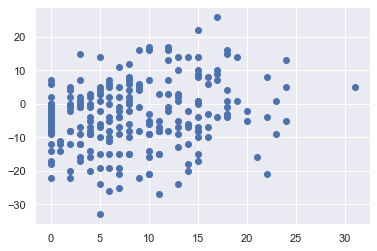

In [267]:
import matplotlib.pyplot as plt
plt.plot(injuries, plus, 'o')

In [200]:
#trying to build a model
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [205]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

ValueError: could not convert string to float: 'Canaan'

In [202]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

ValueError: could not convert string to float: 'Canaan'

In [ ]:
#build a model?
#https://towardsdatascience.com/how-to-build-your-first-machine-learning-model-in-python-e70fd1907cdd

In [ ]:
decision= all_data["Injury Status"]
decision.unique()

array(['Game Time Decision', 'Estimated return 6/30',
       'Probable for start of season',
       'Probable for start of training camp',
       'Probable for start of 2012-13 season',
       'Questionable for start of season',
       'Expected to be out until at least Dec 15',
       'Questionable for start of training camp',
       'Expected to be out until at least Oct 1',
       'Expected to be out until at least Nov 15',
       'Expected to be out until at least Nov 17', 'Out for season',
       'Questionable for start of 2012-13 season',
       'Expected to be out until at least Jan 1',
       'Doubtful for start of 2012-13 season',
       'Expected to be out until at least Nov 13',
       'Expected to be out until at least Nov 19',
       'Expected to be out until at least Dec 11',
       'Expected to be out until at least Oct 30',
       'Expected to be out until at least Nov 10', '20-game suspension',
       'Expected to be out until at least Nov 2',
       'Expected to be ou

In [ ]:
injury["Injury Status"] = 0

In [ ]:
#split the data
#x= alldata.drop

In [ ]:
#functions
#convert to numerica
#build model
#find metrics

# join the profile data to the injury data
#join in pandas, all year data + injury data, joining what I think
#they are stored in
join(load_injury_data, all_year_data)
# get player stats for a season:

# union it together - injury_data- 
# join the injury data to the game data
#every player-game, we have it, join key, join it together
# EF: you need to actually load the data!
season_data = load_profiles("season_data.json.gz")
#build functions for each SeasonType
#CONFUSION- Co
# season_data includes all player-game combinations from all seasons
print(season_data)



#player_profiles
# get a list of player+game
print(player_profiles)
#printing where I think this is stored- CO
# convert all features to numerics
json.parse(player_profiles)
# add derived features / corrections 
# player profile age - current; age at the time of the game is what you need.
age= df[df["AGE"]]
# df: player-game, features..., label
df= pd[player-game]
# split into train/test set that are relatively independent
#model
X= df[player-game]
Y= season_data
# set up an ML algorithm (decision tree, random forest)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# play with the hyperparameters (or use tuning)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
# test on the test set, iterate
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)
print(lr_train_mse)
# save the model 
#used this for code: https://towardsdatascience.com/how-to-build-your-first-machine-learning-model-in-python-e70fd1907cdd


# find the model metrics with respect to the test set (f1, precision, recall, area under roc, etc) 

# when you get a "reasonable" model, stop and make graphs...